In [1]:
# Import the necessary packages
import warnings
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
# Suppress specific future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# Import the clean data
data = pd.read_csv('source/data.csv', low_memory=False)

In [4]:
# Copy of the original dataset for feature engineering and preprocessing
data_processed = data.copy()

In [5]:
# Drop unnecessary columns
data_processed = data_processed.drop(['AccID', 'birth_year', 'vehicleID', 'num_veh'], axis=1)

In [6]:
# Converting 'time', 'day', 'month', and 'year' to float type
data_processed['time'] = data_processed['time'].astype('float64')
data_processed['day'] = data_processed['day'].astype('float64')
data_processed['month'] = data_processed['month'].astype('float64')
data_processed['year'] = data_processed['year'].astype('float64')

In [7]:
# Selecting features and target variable
features = ['lum', 'atm_condition', 'collision_type', 'route_category', 'traffic_regime', 'reserved_lane_code', 
            'longitudinal_profile', 'upstream_terminal_number', 'plan', 'surface_condition', 'infra', 'accident_situation', 
            'traffic_direction', 'vehicle_category', 'fixed_obstacle', 'mobile_obstacle', 'initial_impact_point', 'manv', 
            'motor', 'seat', 'user_category', 'gender', 'reason_travel', 'safety_equipment1', 'maximum_speed', 'age', 
            'lat', 'long', 'distance_upstream_terminal', 'total_number_lanes', 'day', 'time', 'month', 'year']
target = 'gravity'

In [8]:
# Handling categorical features with One Hot Encoding
X = pd.get_dummies(data_processed[features], drop_first=True)
y = data_processed[target]

In [9]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
# Standardization: Fit only on the training data, then apply to both train and test
scaler = StandardScaler()
numerical_columns = X.select_dtypes(include=['float64']).columns

X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

In [11]:
# Check the dimensions
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (358136, 34)
Shape of X_test: (89534, 34)


Apply ML model ---->

In [12]:
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, precision_recall_curve

In [13]:
# Load and preprocess the data
X = pd.get_dummies(data_processed[features], drop_first=True)
y = data_processed[target] - 1

In [14]:
# Apply SMOTE to handle class imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sd10725\AppData\Roaming\Python\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [15]:
# Get unique classes in the resampled data to ensure all are accounted for
unique_classes = np.unique(y_res)
print("Unique classes after SMOTE:", unique_classes) 

Unique classes after SMOTE: [0 1 2 3]


In [16]:
# Set up class weights to handle all classes present
class_weights = {0: 1, 1: 20, 2: 1, 3: 1}  

In [17]:
# Adjust the sample weights for each resampled data point
sample_weights = [class_weights[class_label] for class_label in y_res]

In [18]:
# Define and train the XGBoost model with class weights
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_res, y_res, sample_weight=sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob',
              predictor=None, ...)

In [19]:
# Predict on the test set and evaluate
y_probs = xgb_model.predict_proba(X_test)
y_pred = xgb_model.predict(X_test)

In [20]:
# Initial classification report without threshold adjustment
print("XGBoost Classification Report (Without Threshold Adjustment):")
print(classification_report(y_test, y_pred))

XGBoost Classification Report (Without Threshold Adjustment):
              precision    recall  f1-score   support

           0       0.76      0.77      0.76     37371
           1       0.10      0.80      0.18      2335
           2       0.46      0.12      0.19     13737
           3       0.70      0.58      0.63     36091

    accuracy                           0.59     89534
   macro avg       0.50      0.57      0.44     89534
weighted avg       0.67      0.59      0.61     89534



In [21]:
# Threshold Tuning 
fatal_probs = y_probs[:, 1]  

In [22]:
# Use precision-recall curve to find the best threshold
precision, recall, thresholds = precision_recall_curve(y_test == 1, fatal_probs)

In [23]:
# Find the best threshold based on the highest F1 score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

C:\Users\sd10725\AppData\Local\Temp\ipykernel_15708\3071836308.py:2: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


In [24]:
# Apply the best threshold for fatal accident prediction
y_pred_threshold = (fatal_probs >= best_threshold).astype(int)

In [25]:
# Generate classification report after threshold adjustment for fatalities
print(f"Best Threshold: {best_threshold}")
print("Classification report after threshold tuning for fatalities:")
print(classification_report(y_test == 1, y_pred_threshold))

Best Threshold: 0.9980549812316895
Classification report after threshold tuning for fatalities:
              precision    recall  f1-score   support

       False       0.97      1.00      0.99     87199
        True       0.00      0.00      0.00      2335

    accuracy                           0.97     89534
   macro avg       0.49      0.50      0.49     89534
weighted avg       0.95      0.97      0.96     89534



<Figure size 2000x1200 with 0 Axes>

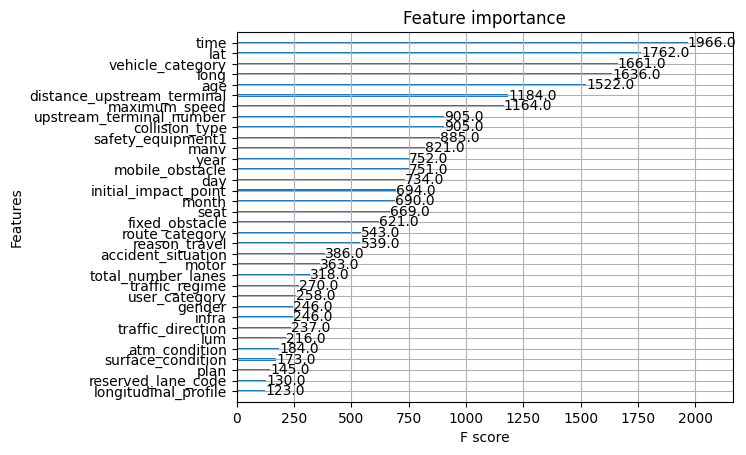

In [26]:
import matplotlib.pyplot as plt

# Train the XGBoost model (use your prepared dataset)
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42, eval_metric='mlogloss')
xgb_model.fit(X_res, y_res)

# Get feature importance from the model
feature_importance = xgb_model.get_booster().get_score(importance_type='weight')

# Plot feature importance
plt.figure(figsize=(20, 12))
xgb.plot_importance(xgb_model, importance_type='weight')
plt.show()


In [27]:
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42,
                              eval_metric='mlogloss',
                              reg_lambda=1,  # L2 regularization (increase to reduce weight variance)
                              reg_alpha=0.5)  # L1 regularization (increase to drive less important features towards zero)

# Train the model
xgb_model.fit(X_res, y_res)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.74      0.82      0.78     37371
           1       0.30      0.15      0.20      2335
           2       0.50      0.46      0.48     13737
           3       0.67      0.65      0.66     36091

    accuracy                           0.68     89534
   macro avg       0.56      0.52      0.53     89534
weighted avg       0.67      0.68      0.67     89534



In [28]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [4, 6, 8],           # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1], # Learning rate
    'min_child_weight': [1, 3, 5],    # Minimum child weight
    'subsample': [0.6, 0.8, 1.0],     # Subsample ratio of training instances
    'colsample_bytree': [0.6, 0.8, 1.0], # Subsample ratio of features
    'gamma': [0, 0.1, 0.2],           # Minimum loss reduction for a split
    'scale_pos_weight': [10, 20, 30]   # Balance class imbalance for fatalities
}

In [29]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=42, eval_metric='mlogloss')

In [30]:
# Initialize GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='f1_macro', cv=3, verbose=2, n_jobs=-1)

In [ ]:
# Fit the model with grid search
grid_search.fit(X_res, y_res)

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


In [ ]:
# Print the best parameters and score
print("Best Hyperparameters: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)

In [ ]:
# Use the best estimator to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
# Classification report for the best model
print("Classification Report for Best Model:")
print(classification_report(y_test, y_pred))